In [12]:
from matplotlib import pyplot as plt
import numpy as np
import random
import re
import sys
import pprint
import collections
import time
import more_itertools as mit
from scipy import sparse
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
def fixCharge(biHeavyAtomList):
    # input is list of "ligand class"
    l1 = biHeavyAtomList[0]
    l2 = biHeavyAtomList[1]
    TotalCharge = l1.charge  # because all charge is stored on the first atom
    bestScore = 10
    bestCharges = [TotalCharge, 0]
    bestBondOrder = 0
    for l1Charge in range(-2, 3):
        for l2Charge in range(-2, 3):
            if TotalCharge == l1Charge + l2Charge:

                numVe1 = (l1.numValE + l1.charge -l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs
                numVe2 = (l2.numValE - l2Charge) - 2 * l2.numLP - 2 * l2.numberOfHs
                
                thisScore = abs(numVe1 - numVe2)
                bondOrder = min(numVe1, numVe2)
                if thisScore <= bestScore and bondOrder < 5 and bondOrder >= 0:
                    bestScore = thisScore
                    bestCharges = [l1Charge, l2Charge]
                    bestBondOrder = bondOrder
    return (bestBondOrder, bestCharges, bestScore)

In [4]:
def fixCharge_bident(biHeavyAtomList):
    # input is list of "ligand class"
    l1 = biHeavyAtomList[0]
    l2 = biHeavyAtomList[1]
    bondScore = 0
    TotalCharge = l1.charge

    bestCharges = [TotalCharge, 0]
    
    bestb12 = 5
    bestb23 = 5
    
    bestCharge1 = 55
    bestCharge2 = 55
    hasSet = False
#     print('l1.numLP: ' + str(l1.numLP)+ ' l2.numLP: ' + str(l2.numLP))
#     print('l1.charge: ' + str(l1.charge))
#     print('l1.numValE: ' + str(l1.numValE)+ ' l2.numValE: ' + str(l2.numValE))
#     print('l1.numberOfHs: ' + str(l1.numberOfHs)+' l2.numberOfHs: ' + str(l2.numberOfHs))
    for l1Charge in range(-2, 3):
        for l2Charge in range(-2, 3):
            if TotalCharge == l1Charge + l2Charge: 

                numVe1 = (l1.numValE + l1.charge - l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs
                numVe2 = (l2.numValE - l2Charge) - 2 * l2.numLP - 2 * l2.numberOfHs

#                 print('numVe1 = (l1.numValE + l1.charge - l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs')
#                 print('numVe1: ' + str(numVe1)  +  ' numVe2: ' + str(numVe2))
#                 print('ve1+2: ' + str(numVe1) + " and " + str(numVe2))    
#                 print('l1Charge: ' + str(l1Charge)+ ' l2Charge: ' + str(l2Charge))
#                 print('1: ' + l1.name + 'H' + str(l1.numberOfHs) + ' charge=' + str(l1.charge))
#                 print('2: ' + l2.name + 'H' + str(l2.numberOfHs) + ' charge=' + str(l2.charge))
                
                if numVe1 > 0 and numVe2 > 1:
#                     print('candidate for bonding')
                    b12list = []
                    for bo in range(1,numVe2+1):
                        b12list.append(np.abs(numVe2 - numVe1 - bo))
                    
                    b12 = np.argmin(b12list)+1
                    b23 = np.min([numVe1, (numVe2 - b12)])
                    
#                     if b12 < bestb12 and b23 < bestb23:
                    if (abs(l1Charge)+abs(l2Charge)) < (abs(bestCharge1)+abs(bestCharge2)):
#                         print('best config with b12: ' + str(b12) + ' and  b23: ' +str(b23) )
                        bestb12 = b12
                        bestb23 = b23
                        bestCharge1 = l1Charge
                        bestCharge2 = l2Charge  
                        bondScore = 1
                        if not hasSet:
                            hasSet = True
                    
    if not hasSet:
        bestb12 = 0
        bestb23 = 0
        bestCharge1 = TotalCharge
        bestCharge2 = 0

    return (bestb12, bestb23, [bestCharge1, bestCharge2], bondScore)

In [13]:
# SC
scSeriesMo = ['[Cl-]', '[OH-]', '[S--]', '[OH2]', '[NH3]',\
               '[PH3]','[SH2]'] #up to NHHH from spectrochemical series, rest heather's excel

scSeriesDi = [
    '[S-]#[S-]', '[C]#4[N-]', '[N-]#4[C]', '[C+]#[O-]', '[N+]=[O]', '[O-]#[O-]']
#              '[C][NH]','[C-][P]','[C][PH]','[C][S]','[N]#[CH]','[N]#[P]','[N+]=[S]',\
#              '[O][C]','[O+][N]','[O+][P]','[O++][P]','[P-]#4[C]','[P]#[CH]','[P]#[N]',\
#              '[P+]=[O]','[P+]=[S]','[S][C]','[S+][N]','[S++][O]','[S+][P]',\
#              '[O-][OH]','[S-][SH]'] # up to O22- is from wiki, rest from heather's table

classicBidentates = ['[NH2]-[CH2]-[CH2]-[NH2]']

boDict = {
    0: '#0',
    1: '-',
    2: '=',
    3: '#',
    4: '#4',
    5: '#5',
    -1: '#-1',
}

## Electronegativity (Pauling) by atom symbol
endict =     { "H" : 2.20, "Li": 0.98, "Be": 1.57, "B" : 2.04, "C" : 2.55, "N" : 3.04, "O" : 3.44,
     "F" : 3.98, "Na": 0.93, "Mg": 1.31, "Al": 1.61, "Si": 1.90, "P" : 2.19, "S" : 2.58,
     "Cl": 3.16, "K" : 0.82, "Ca": 1.00, "Sc": 1.36, "Ti": 1.54, "V" : 1.63, "Cr": 1.66,
    "Mn": 1.55, "Fe": 1.83, "Co": 1.88, "Ni": 1.91, "Cu": 1.90, "Zn": 1.65,  "Ga": 1.81,
    "Ge": 2.01, "As": 2.18, "Se": 2.55, "Br": 2.96, "Mo": 2.16, "Tc": 2.10, "Rh": 2.28,
    "Pd": 2.20, "Ag": 1.93,"Cd": 1.69, "In": 1.78, "Sb": 2.05, "I":  2.66, "Cs": 0.79, 
    "Y":1.22, "Zr":1.33, "Nb":1.60, "Ru":2.20, "La":1.10, "Hf":1.30, "Ta":1.50, "W":2.36, "Re":1.90}

In [14]:
# list of elements with name as key and [total electrons, valence electrons, usually used for bonds] as value
elemList = {
    'C': [6, 4, 4],
    'N': [7, 5, 3],
    'O': [8, 6, 2],
    'P': [15, 5, 3],
    'S': [16, 6, 2]
}  # 'Si':[14,4,4],'Cl':[17,7,1]

components = "CNOPS"
chargeList = range(-2, 3)
# number of H atoms we are sampling through
hList = range(0, 5)


class ligand():
    def __init__(self, name, numberOfHs, charge):
        self.name = name
        self.charge = charge
        self.numberOfHs = numberOfHs
        self.numberOfEs = self.getNumE()
        self.getNumE()

    def print_name(self):
        print(self.name)

    def print_charge(self):
        print(self.charge)

    def print_numberOfHs(self):
        print(self.numberOfHs)

    # CHARGES
    def setCharge(self, charge):
        self.charge = charge
        self.getNumE()

    def incrCharge(self):
        self.charge += 1
        self.getNumE()

    def decrCharge(self):
        self.charge -= 1
        self.getNumE()

    # HYDROGENS
    def setH(self, number):
        self.numberOfHs = number
        self.getNumE()

    def addH(self):
        self.numberOfHs += 1
        self.getNumE()

    def rmH(self):
        self.numberOfHs -= 1
        self.getNumE()

    def getNumE(self):
        self.numLP = int((elemList[self.name][1] - elemList[self.name][2]) / 2)
        self.numValE = elemList[self.name][1]
        self.numE = elemList[self.name][0]
        mod = self.numberOfHs - self.charge
        self.numValE += mod
        self.numE += mod

    def getSmiles(self):
        """Generates a SMILES string. The first row adds hydrogen and the second row charges"""
        # self.SMILES = "[" + self.name + "".join(["H" for i in range(0, self.numberOfHs)])
        # this is for SMILES with HHH instead of H3 etc.
        if self.numberOfHs > 1:
            self.SMILES = "[" + self.name + "H" + str(self.numberOfHs)
        elif self.numberOfHs == 1:
            self.SMILES = "[" + self.name + "H"
        else:
            self.SMILES = "[" + self.name
        self.SMILES += "".join([
            "+" if self.charge > 0 else "-"
            for i in range(0, abs(int(self.charge)))
        ]) + "]"

    def testOctetRule(self):
        """Test whether a mono-heavy-atom ligand fulfills the octet rule. Results < 8 means that there are 
        too many electrons, result > 8 means that there are not enough electrons."""
        result = 8 - self.numValE
        return (result)

    def testValenceShell(self):
        """Since open shell complexes are difficult to converge in DFT, we restrict ourselves to closed shell ones."""
        result = int(not self.numValE % 2)
        return (result)

    def score(self):
        """The health score helps to prune the full enumeration by setting open shell ligands to zero and 
        weights ligands with negative charge more than ligands with positive charge. Greater is better in this
        score."""
        #         score = (10-(-1*self.testOctetRule() if self.testOctetRule() < 0 else 0.5*self.testOctetRule())) #*self.testValenceShell() # removed the testValshell bc it is only relevant for the whole ligand
        score = 4 - np.abs(int(self.testOctetRule()))
        return (score)

Name: Charge + octet + CA = Score
[NH3]: 3 + 4 + 3 = 10
[OH-]: 3 + 4 + 3 = 10
[OH2]: 3 + 4 + 3 = 10
[PH3]: 3 + 4 + 3 = 10
[S--]: 3 + 4 + 3 = 10
[SH2]: 3 + 4 + 3 = 10
All monoatoms: 125
All scored monoatoms: 50
All wished for monoatoms (>7): 29


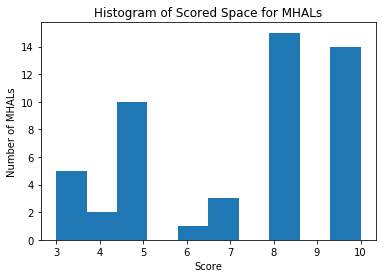

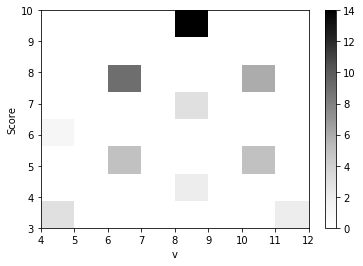

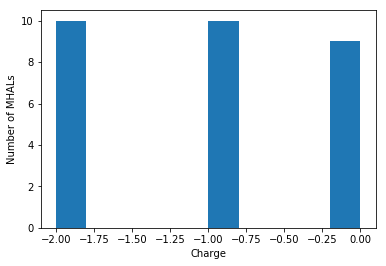

In [15]:
# generate exhaustive output list for mono-ligands
dictMo = {}
scoredDictMo = {}
wishedDictMo = {}

for elem in elemList.keys():
    for charge in chargeList:
        l = ligand(elem, 0, 0)
        l.setCharge(charge)
        for h in hList:
            if h:
                l.addH()
            l.getSmiles()
            dictMo[l.SMILES] = [l.numE,l.numValE,l.numLP,l.charge,l.numberOfHs,\
                                l.testOctetRule(),l.testValenceShell(),l.score(),\
                                endict[elem], l.numberOfHs*(endict[elem]-endict["H"]), l.numberOfHs*(endict[elem]*endict["H"])]
            
for name, line in dictMo.items():
    octetScore = line[7]
    charge = line[3]
    numberOfHs = line[4]
    numValE = line[1]
    closedShell = int(not((numValE)%2))
    # Charge: +1 >= charge >= -3
    # Sterics: 4 >= Number of H at Coordinating Atom (CA)
    # Closed Shell only
    if 1 >= charge and charge >= -3 and closedShell == 1: 
        
        # Charge score
        if charge == 1:
            scoreCharge = 0
        if charge <= 0 and charge >= -2:
            scoreCharge = 3
        elif charge == -3:
            scoreCharge = 0

        # CA Sterics Score
        if numberOfHs == 4:
            scoreCa = 0 
        else:
            scoreCa = 3
    
        # Total score
        score = scoreCharge + octetScore + scoreCa
        
        # Dict with only scored ligands
        dictMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
        scoredDictMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
        
    else:
        score = 0.0
        dictMo[name] = line + [0] + [0] + [0] + [score]

print("Name: Charge + octet + CA = Score")



histCharge = list() # lists of charge, octet difference, occupancy of CA and score to see histograms
histOctet = list()
histCa = list()
histScore = list()
histVE = list()
thresholdMo = 7 #7 define threshold for wishedDictMo
for name, props in scoredDictMo.items():        
#     histCharge.append(props[3])
#     histOctet.append(props[-3])
#     histCa.append(props[-2])
    histScore.append(props[-1])
    histVE.append(props[1])
    
    # Populate the wishedDictMo
    if props[-1] > thresholdMo: 
        wishedDictMo[name] = props
        histCharge.append(props[3])
    
    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(scSeriesMo)):
        if name == scSeriesMo[i]:
            print(name + ': ' +str(props[-4])+" + "+str(props[-3])+" + "+str(props[-2])+' = '+str(props[-1])) 

print('======')
print("All monoatoms: " + str(len(dictMo)))  
print("All scored monoatoms: " + str(len(scoredDictMo)))
print("All wished for monoatoms (>" + str(thresholdMo) + "): " + str(len(wishedDictMo)))
print('======')

plt.xlabel('Score')
plt.ylabel('Number of MHALs')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Scored Space for MHALs')
plt.hist(histScore)
plt.savefig('mhal_ss_hist.pdf', bbox_inches='tight')
plt.show()


plt.hist2d(histVE, histScore, bins=8, cmap = 'Greys')
plt.xlabel('v')
plt.ylabel('Score')
plt.colorbar()
plt.savefig('mhal_ss_score_vs_v_2d_hist.pdf', bbox_inches='tight')
plt.show()

plt.hist(histCharge)
plt.ylabel('Number of MHALs')
plt.xlabel('Charge')
plt.savefig('mhal_ss_hist_charge.pdf', bbox_inches='tight')
plt.show()

# pprint.pprint(re.sub('[\'()a-z_]',"",str(wishedDictMo.keys())))


In [16]:
# # started to translate every dict to lists for MHALs.
# listMo = list()
# scoredlistMo = {}
# wishedlistMo = {}

# smi_ind = 0
# listSmi = list()

# for elem in elemList.keys():
#     for charge in chargeList:
#         l = ligand(elem, 0, 0)
#         l.setCharge(charge)
#         for h in hList:
#             if h:
#                 l.addH()
#             l.getSmiles()
#             listMo.append([l.numE,l.numValE,l.numLP,l.charge,l.numberOfHs,\
#                                 l.testOctetRule(),l.testValenceShell(),l.score()])
#             listSmi.append(l.SMILES)
#             smi_ind += 1
            
# for line in listMo:
#     octetScore = line[7]
#     charge = line[3]
#     numberOfHs = line[4]
#     numValE = line[1]
#     closedShell = int(not((numValE)%2))
#     # Charge: +1 >= charge >= -3
#     # Sterics: 4 >= Number of H at Coordinating Atom (CA)
#     # Closed Shell only
#     if 1 >= charge and charge >= -3 and closedShell == 1: 
        
#         # Charge score
#         if charge == 1:
#             scoreCharge = 0
#         if charge <= 0 and charge >= -2:
#             scoreCharge = 3
#         elif charge == -3:
#             scoreCharge = 0

#         # CA Sterics Score
#         if numberOfHs == 4:
#             scoreCa = 0 
#         else:
#             scoreCa = 3
    
#         # Total score
#         score = scoreCharge + octetScore + scoreCa
        
#         # Dict with only scored ligands
#         listMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
#         scoredlistMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
        
#     else:
#         score = 0.0
#         listMo[name] = line + [0] + [0] + [0] + [score]

# print("Name: Charge + octet + CA = Score")



# histCharge = list() # lists of charge, octet difference, occupancy of CA and score to see histograms
# histOctet = list()
# histCa = list()
# histScore = list()
# histVE = list()
# thresholdMo = 7 # define threshold for wishedlistMo
# for name, props in scoredlistMo.items():        
# #     histCharge.append(props[3])
# #     histOctet.append(props[-3])
# #     histCa.append(props[-2])
#     histScore.append(props[-1])
#     histVE.append(props[1])
    
#     # Populate the wishedlistMo
#     if props[-1] > thresholdMo: 
#         wishedlistMo[name] = props
#         histCharge.append(props[3])
    
#     # Evaluate compounds from Spectrochemical Series
#     for i in range(0, len(scSeriesMo)):
#         if name == scSeriesMo[i]:
#             print(name + ': ' +str(props[-4])+" + "+str(props[-3])+" + "+str(props[-2])+' = '+str(props[-1])) 

# print('======')
# print("All monoatoms: " + str(len(listMo)))  
# print("All scored monoatoms: " + str(len(scoredlistMo)))
# print("All wished for monoatoms (>" + str(thresholdMo) + "): " + str(len(wishedlistMo)))
# print('======')

# plt.xlabel('Score')
# plt.ylabel('Number of MHALs')
# # plt.yscale('log', nonposy='clip')
# plt.title('Histogram of Scored Space for MHALs')
# plt.hist(histScore)
# plt.savefig('mhal_ss_hist.pdf', bbox_inches='tight')
# plt.show()


# plt.hist2d(histVE, histScore, bins=8, cmap = 'Greys')
# plt.xlabel('v')
# plt.ylabel('Score')
# plt.colorbar()
# plt.savefig('mhal_ss_score_vs_v_2d_hist.pdf', bbox_inches='tight')
# plt.show()

# plt.hist(histCharge)
# plt.ylabel('Number of MHALs')
# plt.xlabel('Charge')
# plt.savefig('mhal_ss_hist_charge.pdf', bbox_inches='tight')
# plt.show()

# # pprint.pprint(re.sub('[\'()a-z_]',"",str(wishedlistMo.keys())))

# for i in reversed(range(thresholdMo, 11)):
#     for name, props in wishedlistMo.items():
#         if props[-1] == i:
#             print(name, end=": ")
#             print(props[-1])

In [17]:
# # selection of monos
# print('These are the ' + str(len(wishedDictMo)) + ' structure we wish for:')
# pprint.pprint(wishedDictMo) as

# veMo = {'sixVeMo': 0, 'eightVeMo': 0, 'tenVeMo': 0, 'elseVeMo': 0, 'elseVeMo': 0}
# smVeMo = {'smSixVeMo': [], 'smEightVeMo': [], 'smTenVeMo': [], 'smElseVeMo': [], 'smElseVeMo': []}

# for name, props in wishedDictMo.items():
#     if props[1] == 6:
#         veMo['sixVeMo'] += 1
#         smVeMo["smSixVeMo"].append(name)
#     elif props[1] == 8:
#         veMo['eightVeMo'] += 1
#         smVeMo["smEightVeMo"].append(name)
#     elif props[1] == 10:
#         veMo['tenVeMo'] += 1
#         smVeMo["smTenVeMo"].append(name)
#     else:
#         veMo['elseVeMo'] += 1
#         smVeMo["smElseVeMo"].append(name)

# print('\n Their distribution for 6, 8, and 10 VE: ')
# print(veMo)
# print('\n Their SMILES: ')
# pprint.pprint(smVeMo)
# print('\n')

# selListMo = list()
# rnSixVe = random.sample(range(0, len(smVeMo["smSixVeMo"])), 6)
# for i in range(0, len(rnSixVe)):
#     selListMo.append(smVeMo["smSixVeMo"][rnSixVe[i]])
    
# rnEightVe = random.sample(range(0, len(smVeMo["smEightVeMo"])), 10)
# for i in range(0, len(rnEightVe)):
#     selListMo.append(smVeMo["smEightVeMo"][rnEightVe[i]])
    
# rnTenVe = random.sample(range(0, len(smVeMo["smTenVeMo"])), 4)
# for i in range(0, len(rnTenVe)):
#     selListMo.append(smVeMo["smTenVeMo"][rnTenVe[i]])

# print('\n A random sample of these structures (2/3 of each isoelectronic group): ')
# pprint.pprint(selListMo)   
# print('A total of ' + str(len(selListMo)) + ' Structures.')

In [1]:
# generate exhaustive output list for di-ligands
dictDi = {}
scoredDictDi = {}
wishedDictDi = {}

for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in range(
                -4, 5
        ):  # charge1 on one but from -4 to +4, because charge is not localized in dft
            for h1 in hList:
                for h2 in hList:
                    l1 = ligand(elem1, 0, 0)
                    l1.setCharge(charge1)
                    l1.setH(h1)
                    l2 = ligand(elem2, 0, 0)
                    l2.setCharge(0)  # charge should distribute from first atom
                    l2.setH(h2)
                    bestBondOrder, bestCharges, bestScore = fixCharge([l1, l2])
                    l1.setCharge(bestCharges[0])
                    l2.setCharge(bestCharges[1])
                    l1.getSmiles()
                    l2.getSmiles()
                    diatomName = ''.join(
                        l1.SMILES + boDict[bestBondOrder] + l2.SMILES)
                    dictDi[diatomName] = [l1.numE, l1.numValE, l1.numLP, l1.charge, l1.numberOfHs, \
                                         l1.testOctetRule(), l1.testValenceShell(), l1.score(),\
                                         l2.numE, l2.numValE, l2.numLP, l2.charge, l2.numberOfHs, \
                                         l2.testOctetRule(), l2.testValenceShell(), \
                                         bestBondOrder ,l2.score(), endict[elem1], \
                                         endict[elem1]-endict[elem2]+l1.numberOfHs*(endict[elem1]-endict["H"]),\
                                         endict[elem1]*endict[elem2]+l1.numberOfHs*(endict[elem1]*endict["H"])]
                                            #15, 16, 17, 18, 19

for name, line in dictDi.items():
    charge1 = line[3] 
    charge2 = line[11]
    charge = charge1 + charge2
    numberOfHs = line[4]
    numValE1 = line[1]
    numValE2 = line[9]
    numLP1 = line[2]
    numLP2 = line[10]
    bestBondOrder = line[15]
    closedShell = int(not ((numValE1 + numValE2) % 2))
    # Charge: 1 >= charge >= -4
    # Sterics: 4 >= Number of H at CA
    # Closed Shell only
    if charge <= 1 and numberOfHs < 4 and closedShell == 1 and bestBondOrder > 0:  # overall charge should not exceed +1 and not more than 3 H at CA
        
        # Polarization
        if np.abs(charge1) + np.abs(charge2) == 4:
            scorePol = 0
        elif np.abs(charge1) + np.abs(charge2) == 3:
            scorePol = 1
        else:
            scorePol = 3
        
        # Bond score
        if bestBondOrder == 1 :
            scoreBond = 3
        elif bestBondOrder == 4 or bestBondOrder == 2 or bestBondOrder == 3:
            scoreBond = 2
            
        # Charge score
        if charge == 1:
            scoreCharge = 0
        elif charge == 0:
            scoreCharge = 3
        if charge <= -1 and charge >= -2:
            scoreCharge = 2
        elif charge == -3:
            scoreCharge = 1
        elif charge == -4:
            scoreCharge = 0

        # VSEPR score
        # IS THIS THE SAME AS BOND ORDER
        usual1 = numValE1 - 2 * numLP1 + charge * 0 - 2 * numberOfHs
        usual2 = numValE2 - 2 * numLP2 + line[11] - 2 * line[12]
        scoreVsepr = 5 - np.abs(usual1 - usual2)

        # CA Sterics Score
        if line[4] == 3:
            scoreCa = 0
        else:
            scoreCa = 3

        #Total score
        score =  scorePol + scoreBond + scoreCharge + scoreVsepr + scoreCa 

        # Dict with only scored ligands
#         dictDi[name] = line + [scorePol] + [scoreCharge] + [scoreVsepr] + [scoreCa] + [score]
        scoredDictDi[name] = line + [scorePol] + [scoreBond] + [scoreCharge] + [scoreVsepr] + [scoreCa] + [score]

    else:
        score = 0.0
        dictDi[name] = line + [0] + [0] + [0] + [0] + [0] + [score]

print("Name, Score = Polarization + Bond + Charge + VSEPR + CA")

histCharge = list()
histBO = list()
histVsepr = list()
histCa = list()
histScore = list()
histVE = list()
thresholdDi = 13 #13
histEN = list()

for name, props in scoredDictDi.items():
#     histBO.append(props[15])
#     histCharge.append(props[3]+props[11])
#     histVsepr.append(props[-3])
#     histCa.append(props[-2])
#     histScore.append(props[-1])
#     histVE.append(props[1] + props[9])

    # populate the wishedDictDi
    if props[-1] > thresholdDi:
        wishedDictDi[name] = props
        histBO.append(props[15])
        histCharge.append(props[3]+props[11])
        histVsepr.append(props[-3])
        histCa.append(props[-2])
        histScore.append(props[-1])
        histVE.append(props[1] + props[9])
        histEN.append(props[17])

    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(scSeriesDi)):
        if name == scSeriesDi[i]:
            print(name + ': ' + str(props[-4]) + " + " + str(props[-3]) +
                  " + " + str(props[-2]) + ' = ' + str(props[-1]))

print('======')
print("All diatoms: " + str(len(dictDi)))
print("All scored diatoms: " + str(len(scoredDictDi)))
print("All wished for diatoms (>" + str(thresholdDi) + "): " + str(len(wishedDictDi)))
print('======')

plt.xlabel('Score')
plt.ylabel('Number of DHALs')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Scored Space for DHALs')
plt.hist(histScore)
plt.axvline(thresholdDi, color='black', linestyle='dashed', linewidth=2)
plt.savefig('dhal_ss_hist.pdf', bbox_inches='tight')
plt.show()

plt.hist2d(histScore, histVE, cmap = 'Greys')
plt.xlabel('score')
plt.ylabel('v')
# plt.ylim((0,10))
# plt.xlim((8,22))
plt.savefig('dhal_ss_score_vs_v_2d_hist.pdf', bbox_inches='tight')
plt.colorbar()
plt.show()

plt.hist(histBO)
plt.xlabel('BO')
plt.ylabel('Number of DHALs')
plt.savefig('dhal_ss_hist_bo.pdf', bbox_inches='tight')
plt.show()

plt.hist(histCharge)
plt.xlabel('charge')
plt.ylabel('Number of DHALs')
plt.savefig('dhal_ss_hist_charge.pdf', bbox_inches='tight')
plt.show()

for i in reversed(range(thresholdDi, 18)):
    for name, props in wishedDictDi.items():
        if props[-1] == i:
            print(name, end=": ")
            print(props[-1])

    
plt.hist(histEN)
plt.xlabel('EN')
plt.ylabel('Number of DHALs')
plt.show()

NameError: name 'elemList' is not defined

In [19]:
# # selection of di ligands
# print('These are the ' + str(len(wishedDictDi)) + ' structure we wish for:')
# # pprint.pprint(wishedDictDi)

# veDi = {'VeDi8': 0, 'VeDi10': 0, 'VeDi12': 0, 'VeDi14': 0, 'VeDi16': 0, 'VeDi18': 0}
# smVeDi = {'smVeDi8': [], 'smVeDi10': [], 'smVeDi12': [], 'smVeDi14': [], 'smVeDi16': [], 'smVeDi18': []}

# for name, props in wishedDictDi.items():
#     if props[1] + props[9] == 8:
#         veDi['VeDi8'] += 1
#         smVeDi["smVeDi8"].append(name)
#     elif props[1] + props[9] == 10:
#         veDi['VeDi10'] += 1
#         smVeDi["smVeDi10"].append(name)
#     elif props[1] + props[9] == 12:
#         veDi['VeDi12'] += 1
#         smVeDi["smVeDi12"].append(name)
#     elif props[1] + props[9] == 14:
#         veDi['VeDi14'] += 1
#         smVeDi["smVeDi14"].append(name)
#     elif props[1] + props[9] == 16:
#         veDi['VeDi16'] += 1
#         smVeDi["smVeDi16"].append(name)
#     elif props[1] + props[9] == 18:
#         veDi['VeDi18'] += 1
#         smVeDi["smVeDi18"].append(name)

# print('\n Their distribution for Isoelectronics [8,18]: ')
# print(veDi)
# print('\n Their SMILES: ')
# # pprint.pprint(smVeDi)
# print('\n')

# selListDi = list()
# tuplesList = [(8,1),(10,5),(12,20),(14,30),(16,20),(18,4)]
# for tuples in tuplesList:
#     key = "smVeDi"+str(tuples[0])
#     randInds = random.sample(range(0, len(smVeDi[key])), tuples[1])
#     for inds in randInds:
#         selListDi.append(smVeDi[key][inds])

# print('\n A random sample of these structures (1/5 of each isoelectronic group): ')
# print(selListDi)   
# print('A total of ' + str(len(selListDi)) + ' Structures.')

The 1st [.] is always the CA and the 2nd [.] is the bridging atom:

Name, Score = Polarization (Charge Diff) + CA + Bond + VSEPR 
[NH2]-[CH2]-[CH2]-[NH2]: 5 + 3 + 3 + 5 = 16

All bidentates: 5625
All scored bidentates: 1635
All wished for bidentates: 148


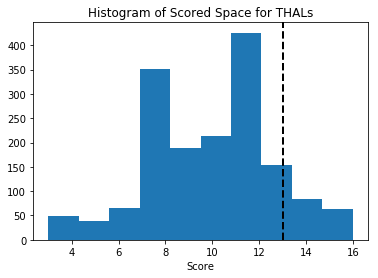

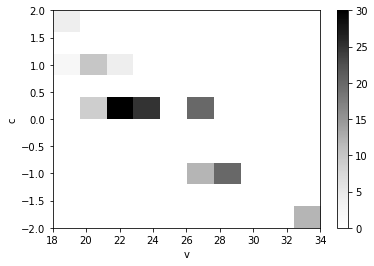

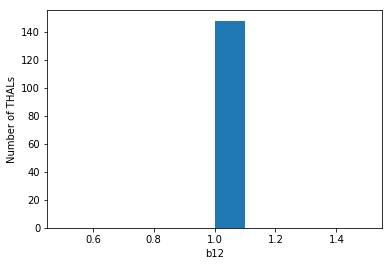

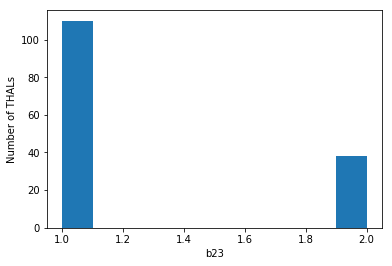

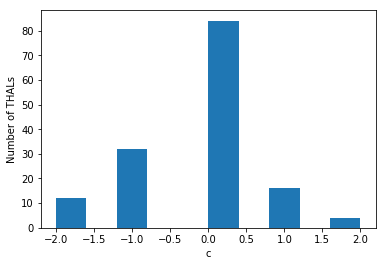

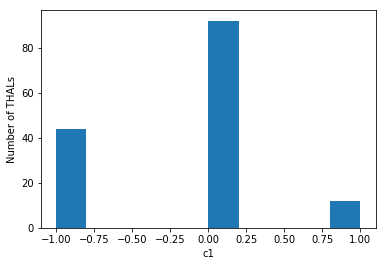

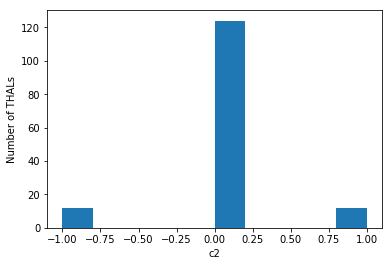

[C]#4[C--]: 15
[CH2--]#4[C]: 15
[CH-]#4[C]: 15
[CH2-]#[CH]: 15
[C+]#[CH2-]: 15
[CH+]=[CH3-]: 15
[CH2-]#[C+]: 15
[CH2-]#[N]: 15
[C+]#[NH-]: 15
[CH+]=[NH2-]: 15
[C+]#[O-]: 15
[CH+]=[OH-]: 15
[CH2-]#[P]: 15
[C+]#[PH-]: 15
[CH+]=[PH2-]: 15
[C+]#[S-]: 15
[CH+]=[SH-]: 15
[NH--]#4[C]: 15
[NH2--]#[CH]: 15
[N-]#4[C]: 15
[NH-]#[CH]: 15
[NH2-]=[CH2]: 15
[NH2]-[CH4-]: 15
[N+]=[CH3-]: 15
[NH-]#[C+]: 15
[NH2-]=[CH+]: 15
[NH2--]#[N]: 15
[NH-]#[N]: 15
[NH2-]=[NH]: 15
[NH2]-[NH3-]: 15
[N+]=[NH2-]: 15
[NH2-]=[N+]: 15
[NH2-]=[O]: 15
[NH2]-[OH2-]: 15
[N+]=[OH-]: 15
[NH2--]#[P]: 15
[NH-]#[P]: 15
[NH2-]=[PH]: 15
[NH2]-[PH3-]: 15
[N+]=[PH2-]: 15
[NH2-]=[P+]: 15
[NH2-]=[S]: 15
[NH2]-[SH2-]: 15
[N+]=[SH-]: 15
[O--]#4[C]: 15
[OH--]#[CH]: 15
[OH2--]=[CH2]: 15
[OH2-]-[CH4-]: 15
[O-]#[CH]: 15
[OH-]=[CH2]: 15
[OH]-[CH4-]: 15
[O-]#[C+]: 15
[OH-]=[CH+]: 15
[OH--]#[N]: 15
[OH2--]=[NH]: 15
[OH2-]-[NH3-]: 15
[O-]#[N]: 15
[OH-]=[NH]: 15
[OH]-[NH3-]: 15
[OH-]=[N+]: 15
[OH2--]=[O]: 15
[OH2-]-[OH2-]: 15
[OH-]=[O]: 15
[OH]-[

In [20]:
# enumeration of all homo-bidentates
usual = list()
dictBident = dict()
scoredDictBident = dict()
wishedDictBident = dict()

for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in range(-4, 5):
            for h1 in hList:
                for h2 in hList:
#                      if h1 ==2 and h2 ==2 and elem1 == "N" and elem2 == "C":
                        l1 = ligand(elem1, 0, 0)
                        l1.setCharge(charge1)
                        l1.setH(h1)
                        l2 = ligand(elem2, 0, 0)
                        l2.setCharge(0)
                        l2.setH(h2)
                        bestBondOrder1, bestBondOrder2, bestCharges, bondScore = fixCharge_bident([l1, l2])
#                         print(bestBondOrder1)
                        l1.setCharge(bestCharges[0])
                        l2.setCharge(bestCharges[1])
                        l1.getSmiles()
                        l2.getSmiles()
                        diatomName = ''.join(
                            l1.SMILES + boDict[bestBondOrder1] + l2.SMILES +
                            boDict[bestBondOrder2] + l2.SMILES +
                            boDict[bestBondOrder1] + l1.SMILES)
                        
                        dictBident[diatomName] = [
                            l1.numE, l1.numValE, l1.numLP, l1.charge,
                            l1.numberOfHs,
                            l1.testOctetRule(),
                            l1.testValenceShell(),
                            l1.score(), l2.numE, l2.numValE, l2.numLP, l2.charge,
                            l2.numberOfHs,
                            bondScore,
                            bestBondOrder1,
                            bestBondOrder2,
                            l2.testOctetRule(),
                            l2.testValenceShell(),
                            l2.score(),
                            endict[elem1], 
                            endict[elem1]-endict[elem2]+l1.numberOfHs*(endict[elem1]-endict["H"]),
                            endict[elem1]*endict[elem2]+l1.numberOfHs*(endict[elem1]*endict["H"])

                        ]

# Figure out how many usuals there are in the nonCAs: {-2,4}.
histUsual = list()

for name, props in dictBident.items():
    charge1 = props[3]
    charge2 = props[11]
    charge = charge1 + charge2
    numberOfHs1 = props[4]
    numberOfHs2 = props[12]
    numValE1 = props[1]
    numValE2 = props[9]
    numLP1 = props[2]
    numLP2 = props[10]
    bondScore = props[13]
    bestBondOrder1 = props[14]
    bestBondOrder2 = props[15]
    if charge < 3 and charge >= -4 and bondScore == 1 and not(bestBondOrder1 >= 2 and bestBondOrder2 >= 2) and not(bestBondOrder1 == 3 or bestBondOrder2 == 3) :
    # charge under 3 and above -4 (actually, they are all in [-2,0])
    # No ##, =#, #=, ==
    # No #-, -#
        
        # Bond score
        if bestBondOrder1 == 1 and bestBondOrder2 == 1:
            scoreBond = 3
        elif bestBondOrder1 == 1 and bestBondOrder2 == 2:
            scoreBond = 3
        elif bestBondOrder1 == 2 and bestBondOrder2 == 1:
            scoreBond = 0
        
        # fulfill octet
        usual1 = numValE1 - 2 * numLP1 + charge1 - 2 * numberOfHs1
        usual2 = numValE2 - 2 * numLP2 + charge2 - 2 * numberOfHs2 - bestBondOrder2
        scoreVsepr = 5 - np.abs(usual1 - usual2)
        
       
        # Charge score
        if charge1 == 0 and charge2 == 0: #0
            scoreChargeDiff = 5
#             print('1')
        elif (charge1 == 1 and charge2 == -1) or (charge1 == -1 and charge2 == 1): #0
            scoreChargeDiff = 3
#             print('2')
        elif charge1 == -1 and charge2 == -1: #-2
            scoreChargeDiff = 3
#             print('3')
        elif charge1 == -2 and charge2 == -2: #-4
            scoreChargeDiff = 0
#             print('4')
        elif (charge1 == 0 and charge2 == -1) or (charge1 == -1 and charge2 == 0): #-1
            scoreChargeDiff = 3
#             print('5')
        elif (charge1 == 2 and charge2 == -1) or (charge1 == -1 and charge2 == 2): #-1
            scoreChargeDiff = 0
#             print('6')
        elif (charge1 == 0 and charge2 == -2) or (charge1 == -2 and charge2 == 0): #-2
            scoreChargeDiff = 2
#             print('7')
        elif (charge1 == -1 and charge2 == -2) or (charge1 == -2 and charge2 == -1): #-3
            scoreChargeDiff = 1
#             print('8')
        elif (charge1 == -2 and charge2 == 0) or (charge1 == 0 and charge2 == -2): #-2
            scoreChargeDiff = 2
#             print('9')
    
        # CA Sterics Score
        if numberOfHs1 == 3 or numberOfHs2 == 3: # 'and' never happens
            scoreCa = 0
        else:
            scoreCa = 3

        #Total score
        score = scoreChargeDiff + scoreCa + scoreBond + scoreVsepr

        scoredDictBident[name] = props + [scoreChargeDiff] + [scoreCa] + [scoreBond] + [scoreVsepr] + [score]
       
    
thresholdBi = 13 #13
histScore = list()
histCa = list()
histCharge = list()
histCharge1 = list()
histCharge2 = list()
histVE = list()
histBond = list()
histBondScore = list()
histBond1 = list()
histBond2 = list()

print("The 1st [.] is always the CA and the 2nd [.] is the bridging atom:\n")
print("Name, Score = Polarization (Charge Diff) + CA + Bond + VSEPR ")
for name, props in scoredDictBident.items():
    histScore.append(props[-1])
#     histBond.append(props[-2])
#     histCa.append(props[-3])
#     histCharge.append(props[-4])
#     histVE.append(2 * (props[1] + props[9]))
#     histBondScore.append(props[13])

    # Populate the wishedDictBident
    if props[-1] > thresholdBi:
        wishedDictBident[name] = props
#         histScore.append(props[-1])
        histBond.append(props[-2])
        histCa.append(props[-3])
        histCharge1.append(props[3])
        histCharge2.append(props[11])
        histCharge.append(props[3]+props[11])
        histVE.append(2 * (props[1] + props[9]))
        histBond1.append(props[14])
        histBond2.append(props[15])

    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(classicBidentates)):
        if name == classicBidentates[i]:
            print(name + ': ' + str(props[-5]) + ' + ' + str(props[-4]) + " + " + str(props[-3]) +
                  " + " + str(props[-2]) + ' = ' + str(props[-1]))
            

print('\n======')
print("All bidentates: " + str(len(dictBident)))
print("All scored bidentates: " + str(len(scoredDictBident)))
print("All wished for bidentates: " + str(len(wishedDictBident)))
print('======')

plt.xlabel('Score')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Scored Space for THALs')
plt.hist(histScore)
plt.axvline(thresholdBi, color='black', linestyle='dashed', linewidth=2)
plt.savefig('thal_ss_hist.pdf', bbox_inches='tight')
plt.show()

plt.hist2d(histVE, histCharge, cmap = 'Greys')
plt.xlabel('v')
plt.ylabel('c')
plt.savefig('thal_ss_score_vs_v_2d_hist.pdf', bbox_inches='tight')
plt.colorbar()
plt.show()

plt.hist(histBond1)
plt.ylabel('Number of THALs')
plt.xlabel('b12')
plt.savefig('thal_ss_hist_b12.pdf', bbox_inches='tight')
plt.show()

plt.hist(histBond2)
plt.ylabel('Number of THALs')
plt.xlabel('b23')
plt.savefig('thal_ss_hist_b23.pdf', bbox_inches='tight')
plt.show()

plt.hist(histCharge)
plt.ylabel('Number of THALs')
plt.xlabel('c')
plt.savefig('thal_ss_hist_charge.pdf', bbox_inches='tight')
plt.show()

plt.hist(histCharge1)
plt.ylabel('Number of THALs')
plt.xlabel('c1')
plt.savefig('thal_ss_hist_c1.pdf', bbox_inches='tight')
plt.show()

plt.hist(histCharge2)
plt.ylabel('Number of THALs')
plt.xlabel('c2')
plt.savefig('thal_ss_hist_c2.pdf', bbox_inches='tight')
plt.show()

for i in reversed(range(thresholdBi, 16)):
    for name, props in wishedDictDi.items():
        if props[-1] == i:
            print(name, end=": ")
            print(props[-1])

In [21]:
###### readout xHALs
lengths = [len(wishedDictMo) + len(wishedDictDi), len(wishedDictBident)]
np.set_printoptions(threshold=np.nan)

propMatMonodentate = np.zeros((lengths[0],5)) # 5 properties: name, tot charge, tot VE, tot EN of CAs diff, tot EN of CAs prod

propMatBidentate = np.zeros((lengths[1],5))

finalMo = list()
finalDi = list()
finalMonodentate = list()
finalBidentate = list()

for i in range(thresholdMo, 20):
    for name, props in wishedDictMo.items():
        if props[-1] == i:
            finalMo.append((name, props[3], props[1], props[8], props[9], props[10]))

for i in range(thresholdDi, 20):
    for name, props in wishedDictDi.items():
        if props[-1] == i:
            # name, charge1+charge2, VE1+VE2, EN of CA = , \Delta \chi
            finalDi.append((name, props[3]+props[11], props[1]+props[9], props[17], props[18], props[19]))

for i in range(thresholdBi, 20):
    for name, props in wishedDictBident.items():
        if props[-1] == i: # entry 6 is CA, -1 for zero based
            finalBidentate.append((name, 2*(props[3]+props[11]), 2*(props[1]+props[9]), props[19], props[20], props[21], props[4]+2*props[12]+3))

finalMonodentate = sorted(finalMo) + sorted(finalDi)
finalBidentate = sorted(finalBidentate)

finalSmiMonodentate = list()
finalSmiBidentate = list()

ind = 0
print('', file=open("finalSmiMonodentate.txt", "w"), end='')
print('', file=open("indicesNeutralHomolepticMonodentates.txt", "w"), end='')
print('', file=open("indicesNeg6HomolepticMonodentates.txt", "w"), end='')
print('', file=open("indicesPos6HomolepticMonodentates.txt", "w"), end='')

for i in finalMonodentate: #405
    print(re.sub('[\',]',"",str(i[0])), file=open("finalSmiMonodentate.txt", "a"), end='') 
    print(" 0", file=open("finalSmiMonodentate.txt", "a"))
    propMatMonodentate[ind,0] = i[1]
    propMatMonodentate[ind,1] = i[2]
    propMatMonodentate[ind,2] = i[3]
    propMatMonodentate[ind,3] = i[4]
    propMatMonodentate[ind,4] = i[5]
    if i[1] == 0:
        print(ind, file=open("indicesNeutralHomolepticMonodentates.txt",'a'))
    elif i[1] == -1:
        print(ind, file=open("indicesNeg6HomolepticMonodentates.txt",'a'))    
    elif i[1] == 1:
        print(ind, file=open("indicesPos6HomolepticMonodentates.txt",'a'))   
    ind += 1
    
print(propMatMonodentate, file=open("propMatMonodentate.txt", "w"))
spMonodentate = sparse.csr_matrix(np.matrix(propMatMonodentate))


ind = 0
print('', file=open("finalSmiBidentate.txt", "w"), end='')
print('', file=open("indicesNeutralHomolepticBidentates.txt", "w"), end='')
print('', file=open("indicesNeg6HomolepticBidentates.txt", "w"), end='')
print('', file=open("indicesPos6HomolepticBidentates.txt", "w"), end='')
for i in finalBidentate: # 148
    finalSmiBidentate.append(i[0])
    smiStr = re.sub('[\',]',"",str(i[0]))
    print(smiStr, file=open("finalSmiBidentate.txt", "a"), end='')
    print(" 1", file=open("finalSmiBidentate.txt", "a"), end='')
    print(" " + str(i[6]+1), file=open("finalSmiBidentate.txt", "a"))
    propMatBidentate[ind,0] = i[1]
    propMatBidentate[ind,1] = i[2]
    propMatBidentate[ind,2] = i[3]
    propMatBidentate[ind,3] = i[4]
    propMatBidentate[ind,4] = i[5]
    # we only allow for complexes in [-6,6] of charge
    if i[1] == 0:
        print(ind, file=open("indicesNeutralHomolepticBidentates.txt",'a'))
    elif i[1] == -2:
        print(ind, file=open("indicesNeg6HomolepticBidentates.txt",'a'))    
    elif i[1] == 2:
        print(ind, file=open("indicesPos6HomolepticBidentates.txt",'a'))   
    ind += 1
print(propMatBidentate, file=open("propMatBidentate.txt", "w"))
spBidentate = sparse.csr_matrix(np.matrix(propMatBidentate))
    
print('Number of Monodentates: ' + str(len(finalMonodentate)))
print('Number of Bidentates: ' + str(len(finalBidentate)), end='\n\n')

Number of Monodentates: 405
Number of Bidentates: 148



In [253]:
###########################
# BIDENTATES BELOW HERE #
###########################

# Generate Homoleptic Bidentates 
start_time = time.time()
homolepBidentatesProj = sparse.diags(np.ones(lengths[1]) * 3)
pickle.dump(homolepBidentatesProj, file=open("homolepBidentatesProj.p", "wb"), protocol=2)
print("Number of Homoleptic Bidentate Complexes: " + str((homolepBidentatesProj.getnnz())))
pickle.dump(homolepBidentatesProj * spBidentate, file=open("homolepBidentates.p", "wb"))
print("My Homoleptic Bidentates took " + str(time.time() - start_time) + "s to permute")
print('\n')

Number of Homoleptic Bidentate Complexes: 148
My Homoleptic Bidentates took 0.003468751907348633s to permute




In [59]:
# Generate Weak Sym Matrix Bidentates <<<<<<<<<<<<<<<<<<<<<<<<<<<3

start_time = time.time()
# weaksymBidentatesProj  = np.zeros(lengths[0]+lengths[1])
# weaksymBidentatesProjA = np.zeros(lengths[0]) # mono part lengths[0]
# weaksymBidentatesProjB = np.zeros(lengths[1]) # bi part lengths[1]

# weaksymBidentatesProjA[0] = 1
# weaksymBidentatesProjA[1] = 1  # we have two mono- and one bidentate
# weaksymBidentatesProjB[0] = 1 

# weaksymBidentatesProjA = sparse.csr_matrix(np.array(list(mit.distinct_permutations(weaksymBidentatesProjA))))
# weaksymBidentatesProjB = sparse.csr_matrix(np.array(list(mit.distinct_permutations(weaksymBidentatesProjB))))

# flag = 1
# for i in range(0,weaksymBidentatesProjB.getnnz()): # give 148 parts because we have bidentates in outer loop weaksymBidentatesProjB.getnnz()
#     weaksymBidentatesProj  = np.zeros(lengths[0]+lengths[1])
#     for j in range(0, int(weaksymBidentatesProjA.getnnz()/2)): #int(weaksymBidentatesProjA.getnnz()/2)
#         if flag == 1:
#             weaksymBidentatesProj = sparse.hstack([weaksymBidentatesProjA.getrow(j), weaksymBidentatesProjB.getrow(i)])
#             flag = 0
#         else: # to prevent the first entry from being just a zero thing
#             weaksymBidentatesProj = sparse.vstack([weaksymBidentatesProj, sparse.hstack([weaksymBidentatesProjA.getrow(j), weaksymBidentatesProjB.getrow(i)])])
            
#     print(str(i) + ': ' + str(time.time() - start_time))
#     pickle.dump(weaksymBidentatesProj, file=open("weaksymBidentatesProj/weaksymBidentatesProj_" + str('{:03}'.format(i)) + ".p", "wb"), protocol=2)  

for k in range(0, weaksymBidentatesProjB.getnnz()): # this could be done in the loop above but we dont because we split it up 
    partial_weaksymBidentatesProj = pickle.load( open("weaksymBidentatesProj/weaksymBidentatesProj_" + str('{:03}'.format(k)) + ".p", "rb" ) )
    
    pickle.dump(partial_weaksymBidentatesProj * sparse.vstack([spMonodentate, spBidentate]), file=open("weaksymBidentates/weaksymBidentates_" + str('{:03}'.format(k)) + ".p", "wb"))


NameError: name 'weaksymBidentatesProjB' is not defined

In [24]:
# Generate Strong Sym BIDENTATES axially connected (ac)
start_time = time.time()
strongsymAcBidentatesProj = np.zeros(lengths[1])
strongsymAcBidentatesProj[0] = 1
strongsymAcBidentatesProj[1] = 2 # two bidentates give the 4 CA in the eq plane
strongsymAcBidentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(strongsymAcBidentatesProj))))
pickle.dump(strongsymAcBidentatesProj, file=open("strongsymAcBidentatesProj.p", "wb"), protocol=2)
print("Number of Strong Sym Bidentate Complexes: " + str(strongsymAcBidentatesProj.getnnz()/2))
pickle.dump(strongsymAcBidentatesProj * spBidentate, file=open("strongsymAcBidentates.p", "wb"))
print("My Strongly Symmetric Complexes took " + str(time.time() - start_time) + "s to permute")

Number of Strong Sym Bidentate Complexes: 21756.0
My Strongly Symmetric Complexes took 1.852250576019287s to permute


In [53]:
# Generate Strong Sym BIDENTATES axially DISconnected (adc) MIXED bi/mono
start_time = time.time()
# strongsymAdcBidentatesProj  = np.zeros(lengths[0]+lengths[1])
strongsymAdcBidentatesProjA = np.zeros(lengths[0]) # mono part lengths[0]
strongsymAdcBidentatesProjB = np.zeros(lengths[1]) # bi part lengths[1]

strongsymAdcBidentatesProjA[0] = 1
strongsymAdcBidentatesProjB[0] = 1 

strongsymAdcBidentatesProjA = sparse.csr_matrix(np.array(list(mit.distinct_permutations(strongsymAdcBidentatesProjA))))
strongsymAdcBidentatesProjB = sparse.csr_matrix(np.array(list(mit.distinct_permutations(strongsymAdcBidentatesProjB))))

flag = 1
for i in range(0, strongsymAdcBidentatesProjA.getnnz()):
    for j in range(0, strongsymAdcBidentatesProjB.getnnz()):
        if flag == 1:
            strongsymAdcBidentatesProj = sparse.hstack([strongsymAdcBidentatesProjA.getrow(i), strongsymAdcBidentatesProjB.getrow(j)])
            flag = 0
        else: # to prevent the first entry from being just a zero thing
            strongsymAdcBidentatesProj = sparse.vstack([strongsymAdcBidentatesProj, sparse.hstack([strongsymAdcBidentatesProjA.getrow(i), strongsymAdcBidentatesProjB.getrow(j)])])

            # strongsymAdcBidentatesProj = np.delete(strongsymAdcBidentatesProj, 0, axis=0)  # remove initialize zeros row       

pickle.dump(strongsymAdcBidentatesProj, file=open("strongsymAdcBidentatesProj.p", "wb"), protocol=2)
print("Number of Strong Sym ADC Bidentate Complexes: " + str(strongsymAdcBidentatesProj.getnnz()/2))
pickle.dump(strongsymAdcBidentatesProj * sparse.vstack([spMonodentate, spBidentate]), file=open("strongsymAdcBidentates.p", "wb"))
print("My Strongly Symmetric Complexes took " + str(time.time() - start_time) + "s to permute")

Number of Strong Sym ADC Bidentate Complexes: 59940.0
My Strongly Symmetric Complexes took 66.2125780582428s to permute


In [53]:
# Generate equatorially asym BIDENTATES axially connected (ac) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< FRI MAY 4: change to generate two matrices to distinguish 1 and 1'=2
start_time = time.time()
eqasymAcBidentatesProj = np.zeros(lengths[1] - 1) # minus 1 because we took out '4' and introduce it later by instertion to split up the calculation
eqasymAcBidentatesProj[0] = 1
eqasymAcBidentatesProj[1] = 1
eqasymAcBidentatesProjBlock = np.array(list(mit.distinct_permutations(eqasymAcBidentatesProj)))
print("My eqasym AC bident Complexes took " + str(time.time() - start_time) + " s to permute")

for k in range(0, np.shape(eqasymAcBidentatesProjBlock)[1] + 1): # plus 1 because we also want an insertion after the last item: np.shape(eqasymAcBidentatesProjBlock)[1] + 1
    #this will have a 0-line as a first line in every block
    eqasymAcBidentatesProj = sparse.csr_matrix(np.zeros(np.shape(eqasymAcBidentatesProjBlock)[1] + 1)) # plus 1 because we also want an insertion after the last item
    eqasymAcBidentatesProjForRacsDistinguishable = sparse.csr_matrix(np.zeros(np.shape(eqasymAcBidentatesProjBlock)[1] + 1))
    for i in eqasymAcBidentatesProjBlock:
        eqasymAcBidentatesProj = sparse.vstack([eqasymAcBidentatesProj, sparse.csr_matrix(np.insert(i, k, 1))])
        eqasymAcBidentatesProjForRacsDistinguishable = sparse.vstack([eqasymAcBidentatesProjForRacsDistinguishable, sparse.csr_matrix(np.insert(i, k, 2))])
    pickle.dump(eqasymAcBidentatesProj, file=open("eqasymAcBidentatesProj/eqasymAcBidentatesProj_" + str('{:03}'.format(k)) + ".p", "wb"), protocol = 2)
    pickle.dump(eqasymAcBidentatesProjForRacsDistinguishable, file=open("eqasymAcBidentatesProj/eqasymAcBidentatesProjForRacsDistinguishable_" + str('{:03}'.format(k)) + ".p", "wb"), protocol = 2)
    print(str(k) + ': ' + str((time.time() - start_time)) + ' s')

print(np.shape(eqasymAcBidentatesProjBlock)[1] + 1)   
for k in range(0, np.shape(eqasymAcBidentatesProjBlock)[1] + 1): # this could be done in the loop above but we dont because we split it up np.shape(eqasymAcBidentatesProjBlock)[1] + 1
    partial_eqasymAcBidentatesProj = pickle.load( open("eqasymAcBidentatesProj/eqasymAcBidentatesProj_" + str('{:03}'.format(k)) + ".p", "rb" ) )
    pickle.dump(partial_eqasymAcBidentatesProj * spBidentate, file=open("eqasymAcBidentates/eqasymAcBidentates_" + str('{:03}'.format(k)) + ".p", "wb"), protocol = 2)

My eqasym AC bident Complexes took 0.8421716690063477 s to permute
0: 7.122774362564087 s
1: 13.173807382583618 s
2: 19.203762531280518 s
3: 25.411353826522827 s
4: 31.42447566986084 s
5: 37.43806266784668 s
6: 43.44443225860596 s
7: 49.486178159713745 s
8: 55.473628520965576 s
9: 61.57978129386902 s
10: 67.59516954421997 s
11: 73.5907084941864 s
12: 79.59305882453918 s
13: 85.628826379776 s
14: 91.66091227531433 s
15: 97.77088832855225 s
16: 103.8112154006958 s
17: 109.84823846817017 s
18: 115.86808586120605 s
19: 121.86237287521362 s
20: 127.85613679885864 s
21: 133.82772755622864 s
22: 139.81771969795227 s
23: 145.8371798992157 s
24: 151.8580915927887 s
25: 157.9175317287445 s
26: 163.9079234600067 s
27: 169.87124037742615 s
28: 175.8433177471161 s
29: 181.8881471157074 s
30: 187.9151473045349 s
31: 193.88655352592468 s
32: 199.8654260635376 s
33: 205.88301873207092 s
34: 211.94216918945312 s
35: 217.965411901474 s
36: 223.9680449962616 s
37: 229.99028134346008 s
38: 236.03992700576

In [330]:
# Generate equatorially asym BIDENTATES axially disconnected (adc) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< FRI 27 APRIL start DONE
start_time = time.time()
## eqasymAdcBidentatesProj  = np.zeros(lengths[0]+lengths[1])
# eqasymAdcBidentatesProjA = np.zeros(lengths[0]) # mono part lengths[0]
# eqasymAdcBidentatesProjB = np.zeros(lengths[1]) # bi part lengths[1]

# eqasymAdcBidentatesProjA[0] = 1
# eqasymAdcBidentatesProjB[0] = 1
# eqasymAdcBidentatesProjB[1] = 1

# eqasymAdcBidentatesProjA = sparse.csr_matrix(np.array(list(mit.distinct_permutations(eqasymAdcBidentatesProjA))))
# eqasymAdcBidentatesProjB = sparse.csr_matrix(np.array(list(mit.distinct_permutations(eqasymAdcBidentatesProjB))))

# print('Took so much to generate perms: ' + str(time.time() - start_time))

# flag = 1
# for i in range(0, eqasymAdcBidentatesProjA.getnnz()): # eqasymAdcBidentatesProjA.getnnz()
#     eqasymAdcBidentatesProj = sparse.csr_matrix(np.zeros(lengths[0]+lengths[1]))
#     for j in range(0, int(eqasymAdcBidentatesProjB.getnnz()/2)):
#         if flag == 1:
#             eqasymAdcBidentatesProj = sparse.hstack([eqasymAdcBidentatesProjA.getrow(i), eqasymAdcBidentatesProjB.getrow(j)])
#             flag = 0
#         else: # to prevent the first entry from being just a zero thing
#             eqasymAdcBidentatesProj = sparse.vstack([eqasymAdcBidentatesProj, sparse.hstack([eqasymAdcBidentatesProjA.getrow(i), eqasymAdcBidentatesProjB.getrow(j)])])

#     print(str(i) + ': ' + str((time.time() - start_time)/60) + ' min')
#     pickle.dump(eqasymAdcBidentatesProj, file=open("eqasymAdcBidentatesProj/eqasymAdcBidentatesProj_" + str('{:03}'.format(i)) + ".p", "wb"), protocol=2)  
    
for k in range(0, eqasymAdcBidentatesProjA.getnnz()): # this could be done in the loop above but we dont because we split it up 
    partial_eqasymAdcBidentatesProj = pickle.load( open("eqasymAdcBidentatesProj/eqasymAdcBidentatesProj_" + str('{:03}'.format(k)) + ".p", "rb" ) )
    pickle.dump(partial_eqasymAdcBidentatesProj * sparse.vstack([spMonodentate, spBidentate]), file=open("eqasymAdcBidentates/eqasymAdcBidentates_" + str('{:03}'.format(k)) + ".p", "wb"))
    print(k, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [22]:
# Generate 4+2 BIDENTATES 
start_time = time.time()
fourtwosymBidentatesProj = np.zeros(lengths[1])
fourtwosymBidentatesProj[0] = 1
fourtwosymBidentatesProj[1] = 2 # two bidentates give the 4 CA in the eq plane
fourtwosymBidentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(fourtwosymBidentatesProj))))
pickle.dump(fourtwosymBidentatesProj, file=open("fourtwosymBidentatesProj.p", "wb"), protocol=2)
print("Number of Strong Sym Bidentate Complexes: " + str(fourtwosymBidentatesProj.getnnz()/2))
pickle.dump(fourtwosymBidentatesProj * spBidentate, file=open("fourtwosymBidentates.p", "wb"), protocol=2)
print("My Strongly Symmetric Complexes took " + str(time.time() - start_time) + "s to permute")

Number of Strong Sym Bidentate Complexes: 21756.0
My Strongly Symmetric Complexes took 1.836488962173462s to permute


In [315]:
###########################
# MONODENTATES BELOW HERE #
###########################

np.set_printoptions(threshold=np.nan)

# Generate Homoleptic Matrix
start_time = time.time()
homolepMonodentatesProj = sparse.diags(np.ones(lengths[0]) * 6)
pickle.dump(homolepMonodentatesProj, file=open("homolepMonodentatesProj.p", "wb"), protocol=2)
print("Number of Homoleptic Monodentate Complexes: " + str((homolepMonodentatesProj.getnnz())))
pickle.dump(homolepMonodentatesProj * spMonodentate, file=open("homolepMonodentates.p", "wb"))
print("My Homoleptics took " + str(time.time() - start_time) + "s to permute")
print('\n')

Number of Homoleptic Monodentate Complexes: 405
My Homoleptics took 0.0035300254821777344s to permute




In [23]:
# Generate Weak Sym Matrix mono
from sys import getsizeof
start_time = time.time()
weaksymMonodentatesProj = np.zeros(lengths[0] - 1) # minus 1 because we took out '4' and introduce it later by instertion to split up the calculation
weaksymMonodentatesProj[0] = 1
weaksymMonodentatesProj[1] = 1
## weaksymMonodentatesProj[2] = 4
## weaksymMonodentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(weaksymMonodentatesProj))))
# weaksymMonodentatesProjBlock = np.array(list(mit.distinct_permutations(weaksymMonodentatesProj)))
print("My Weakly Symmetric Complexes took " + str(time.time() - start_time) + "s to permute")

# # weaksymMonodentatesProjBlock is the permutation without the "4", we initialize a proj mat and store every 4-insertion into a *.p file.
# # we didnt have the proj * props here yet (before we'd need a vstack of all the block-proj)
# => we run these lines bellow, see all output files in enum/weaksymMonodentatesProj. Took about 6 h.
# for k in range(1, np.shape(weaksymMonodentatesProjBlock)[1] + 1): # plus 1 because we also want an insertion after the last item: np.shape(weaksymMonodentatesProjBlock)[1] + 1
#     weaksymMonodentatesProj = sparse.csr_matrix(np.zeros(np.shape(weaksymMonodentatesProjBlock)[1] + 1)) # plus 1 because we also want an insertion after the last item
#     for i in weaksymMonodentatesProjBlock:
#         weaksymMonodentatesProj = sparse.vstack([weaksymMonodentatesProj, sparse.csr_matrix(np.insert(i, k, 4))])
#     pickle.dump(weaksymMonodentatesProj, file=open("weaksymMonodentatesProj/weaksymMonodentatesProj_" + str('{:03}'.format(k)) + ".p", "wb"))

# => we run these lines bellow, see all output files in enum/weaksymMonodentates. Took about 30 s.
for k in range(0, np.shape(weaksymMonodentatesProjBlock)[1] + 1): # this could be done in the loop above but we dont because we split it up np.shape(weaksymMonodentatesProjBlock)[1] + 1
    partial_weaksymMonodentatesProj = pickle.load( open("weaksymMonodentatesProj/weaksymMonodentatesProj_" + str('{:03}'.format(k)) + ".p", "rb" ) )
    pickle.dump(partial_weaksymMonodentatesProj * spMonodentate, file=open("weaksymMonodentates/weaksymMonodentates_" + str('{:03}'.format(k)) + ".p", "wb"))

NameError: name 'weaksymMonodentatesProjBlock' is not defined

In [316]:
# Generate Strong Sym Matrix
start_time = time.time()
strongsymMonodentatesProj = np.zeros(lengths[0])
strongsymMonodentatesProj[0] = 2
strongsymMonodentatesProj[1] = 4
strongsymMonodentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(strongsymMonodentatesProj))))
pickle.dump(strongsymMonodentatesProj, file=open("strongsymMonodentatesProj.p", "wb"), protocol=2)
print("Number of Strong Sym Monodentate Complexes: " + str(strongsymMonodentatesProj.getnnz()/2))
pickle.dump(strongsymMonodentatesProj * spMonodentate, file=open("strongsymMonodentates.p", "wb"))
print("My Strongly Symmetric Complexes took " + str(time.time() - start_time) + "s to permute")

Number of Strong Sym Monodentate Complexes: 163620.0
My Strongly Symmetric Complexes took 37.51969242095947s to permute


In [18]:
# Generate fiveone Sym Matrix
start_time = time.time()
fiveonesymMonodentatesProj = np.zeros(lengths[0])
fiveonesymMonodentatesProj[0] = 1
fiveonesymMonodentatesProj[1] = 5
fiveonesymMonodentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(fiveonesymMonodentatesProj))))
pickle.dump(fiveonesymMonodentatesProj, file=open("fiveonesymMonodentatesProj.p", "wb"), protocol=2)
print("Number of \"5+1\"-symmetrical Monodentate Complexes: " + str(fiveonesymMonodentatesProj.getnnz()/2))
pickle.dump(fiveonesymMonodentatesProj * spMonodentate, file=open("fiveonesymMonodentates.p", "wb"))
print("My \"5+1\" Complexes took " + str(time.time() - start_time) + "s to permute")
print('\n')

Number of "5+1"-symmetrical Monodentate Complexes: 163620.0
My "5+1" Complexes took 37.696892976760864s to permute




In [101]:
# Generate fourtwosym Matrix
start_time = time.time()
fourtwosymMonodentatesProj = np.zeros(lengths[0])
fourtwosymMonodentatesProj[0] = 2
fourtwosymMonodentatesProj[1] = 4
fourtwosymMonodentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(fourtwosymMonodentatesProj))))
pickle.dump(fourtwosymMonodentatesProj, file=open("fourtwosymMonodentatesProj.p", "wb"), protocol=2)
print("Number of \"4+2\"-symmetrical Monodentate Complexes: " + str(fourtwosymMonodentatesProj.getnnz()/2))
pickle.dump(fourtwosymMonodentatesProj * spMonodentate, file=open("fourtwosymMonodentates.p", "wb"))
print("My \"4+2\" Complexes took " + str(time.time() - start_time) + "s to permute")
print('\n')

Number of "4+2"-symmetrical Monodentate Complexes: 163620.0
My "4+2" Complexes took 37.41836500167847s to permute




In [58]:
# Generate equatorially asym Matrix mono <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< DONE. added a 2'=3 matrix 
from sys import getsizeof
start_time = time.time()
eqasymMonodentatesProj = np.zeros(lengths[0] - 1) # minus 1 because we took out '2' and introduce it later by instertion to split up the calculation
# first we thought we wouldnt need them bc they create degeneracies (2=2), but we need them since axial is different from eq.
eqasymMonodentatesProj[0] = 2
eqasymMonodentatesProj[1] = 2
## eqasymMonodentatesProj[2] = 2
## eqasymMonodentatesProj = sparse.csr_matrix(np.array(list(mit.distinct_permutations(eqasymMonodentatesProj))))
# do this first, about 16 s
eqasymMonodentatesProjBlock = np.array(list(mit.distinct_permutations(eqasymMonodentatesProj)))
print("My eq asym mono Complexes took " + str(time.time() - start_time) + "s to permute")

# eqasymMonodentatesProjBlock is the permutation without the last "s", we initialize a proj mat and store every s-insertion into a *.p file.
# we didnt have the proj * props here yet (before we'd need a vstack of all the block-proj)
# => we run these lines below, see all output files in enum/eqasymMonodentatesProj. Took about 4 h.
for k in range(0, np.shape(eqasymMonodentatesProjBlock)[1] + 1 ): # plus 1 because we also want an insertion after the last item: np.shape(eqasymMonodentatesProjBlock)[1] + 1 
#     eqasymMonodentatesProj = sparse.csr_matrix(np.zeros(np.shape(eqasymMonodentatesProjBlock)[1] + 1)) # plus 1 because we also want an insertion after the last item
    eqasymMonodentatesProjForRacsDistinguishable = sparse.csr_matrix(np.zeros(np.shape(eqasymMonodentatesProjBlock)[1] + 1))
    for i in eqasymMonodentatesProjBlock:
        eqasymMonodentatesProj = sparse.vstack([eqasymMonodentatesProj, sparse.csr_matrix(np.insert(i, k, 2))])
        eqasymMonodentatesProjForRacsDistinguishable = sparse.vstack([eqasymMonodentatesProjForRacsDistinguishable, sparse.csr_matrix(np.insert(i, k, 3))])
    pickle.dump(eqasymMonodentatesProj, file=open("eqasymMonodentatesProj/eqasymMonodentatesProj_" + str('{:03}'.format(k)) + ".p", "wb"))
    pickle.dump(eqasymMonodentatesProjForRacsDistinguishable, file=open("eqasymMonodentatesProj/eqasymMonodentatesProjForRacsDistinguishable_" + str('{:03}'.format(k)) + ".p", "wb"), protocol = 2)
    print(k, end=' ')
print('took ' + str(time.time() - start_time))

# => we run these lines bellow, see all output files in enum/eqasymMonodentates. Took about 30 s.
# for k in range(0, np.shape(eqasymMonodentatesProjBlock)[1] + 1): # this could be done in the loop above but we dont because we split it up np.shape(eqasymMonodentatesProjBlock)[1] + 1
#     partial_eqasymMonodentatesProj = pickle.load( open("eqasymMonodentatesProj/eqasymMonodentatesProj_" + str('{:03}'.format(k)) + ".p", "rb" ) )
#     pickle.dump(partial_eqasymMonodentatesProj * spMonodentate, file=open("eqasymMonodentates/eqasymMonodentates_" + str('{:03}'.format(k)) + ".p", "wb"))

My eq asym mono Complexes took 16.601659536361694s to permute
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 

In [15]:
# # gdb9 analysis
# import collections

# gdb4 = "CNOCCCNCOCCCOCCCCCNCCONCOCCCCCOCOCCCCCCOCCOCCCONNCONCCCCCCCOCCCCCCCNNCCNOCCCOCCNOCCOCCCCCCCCCCCNNCCNOCCCOCCNCCCOCNCOCOCOOCCOCCCCCCCOCCOCOCCOCCCCCCCOCNCCOCCCCCCCCCOC"
# c_gdb4 = collections.Counter(gdb4)
# print(sorted(c_gdb4.items(), key=lambda c_gdb4: c_gdb4[0]))
# print(gdb4)
# print("\n")

# slu1 = str()
# # validDictMo can be CNO only if i just regex out the HSP ones. In diatoms I need to reassemble.
# for name, prop in validDictMo.items():
#     slu1 += re.sub('[\]\[\+\-HSP]','',name)
# print(''.join(slu1))
# c_slu1 = collections.Counter(slu1)
# print(sorted(c_slu1.items(), key=lambda c_slu1: c_slu1[0]))
# print("\n")

# slu2 = str()
# for name, prop in validDictDi.items():
#     if 'P' in name or 'S' in name:
#         continue
#     else:
#         slu2 += re.sub('[\]\[\+\-H]','',name)
# print(''.join(slu2))
# c_slu2 = collections.Counter(slu2)
# print(sorted(c_slu2.items(), key=lambda c_slu2: c_slu2[0]))
# print("\n")

# slu4 = str()
# for name, prop in dictBident.items():
#     if 'P' in name or 'S' in name:
#         continue
#     else:
#         slu4 += re.sub('[\]\[\+\-H]','',name)
# print(''.join(slu4))
# c_slu4 = collections.Counter(slu4)
# print(sorted(c_slu4.items(), key=lambda c_slu4: c_slu4[0]))


In [16]:
# plt.xlabel('Part Score')
# plt.ylabel('Number of Ligands')
# # plt.yscale('log', nonposy='clip')
# plt.title('Histogram of Ca origianl ['+ components + "]")
# plt.hist(histVsepr)
# # plt.savefig('histCa' + components + ".pdf", bbox_inches='tight')
# plt.show()

In [17]:
# first version of scoring

# ## only negatively charged ligands
# outputListDiNeg = []
# scoreDiNeg = []
# for line in outputListDi:
#     # only consider negatively charged di-heavy-atoms
#     if line[4] <= 0 or line[13] <= 0:
#         # higher is better
#         scoreCharge = 3 if line[4] + line[13] >= -2 else line[4] + line[13] + 4
#         scoreCharge -= 3 if line[4] + line[13] > 0 else 0

#         usual1 = line[2] - 2*line[3] + line[4] - 2*line[5]
#         usual2 = line[11] - 2*line[12] + line[13] - 2*line[14]
#         scoreVsepr = 5-np.abs(usual1-usual2)
        
#         # THEY ARENT[[since both AB and BA is created, we remove the ones that are A=B]]
#         # the first atom is the CA and we punish >=3 H on it.
#         if line[5] == 4:
#             scoreCa = 0
#         elif line[5] == 3:
#             scoreCa = 1
#         else:
#             scoreCa = 4
        
#         scoreClosedShell = int(not((line[2]+line[11])%2))

#         score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[8] + 0.5 * line[17])*scoreClosedShell
#         scoreDiNeg.append(score)
        
#         outputListDiNeg.append([line,score])
#     else:
#         continue

# # gives 5625 (total 15625 * 9/25, since there are 25 comb of [-2,+2], 9 of which contain a pos sign)    

# # for s in outputListDiNeg:
# #     print(*s)
# k=0
# score = np.zeros(len(outputListDiNeg))
# for i in range(0, len(outputListDiNeg)):
#     score[i] = outputListDiNeg[i][1]
#     if score[i] > 3:
#         k += 1
# #         print(outputListDiNeg[i])
# print(k)    

# plt.xlabel('Score')
# plt.ylabel('Number of Ligands')
# plt.title('Histogram of Ligands ['+ components + "]")
# plt.hist(score)
# # plt.savefig('distr_' + components + ".pdf", bbox_inches='tight')
# plt.show()



In [18]:
# # plot the number of ligands sorted by the number of electrons (isoelectronic structures)

# numBins = len(np.unique(isoList))

# plt.hist(isoList, bins = numBins, facecolor='green')
# plt.xlabel('Number of Electrons')
# plt.ylabel('Number of Ligands')
# plt.title('Histogram of Isoelectronic Ligands ['+ components + "]")
# plt.xticks(np.unique(isoList))
# # plt.savefig('hist_iso_ligands_' + components + ".pdf", bbox_inches='tight')
# plt.show()


In [19]:
# # plot the number of ligands sorted by the number of VE (VE-isoelectronic structures)

# numBins = len(np.unique(veList))

# plt.hist(veList, bins = numBins, facecolor='green')
# plt.xlabel('Number of Valence Electrons (VE) ['+ components + "]")
# plt.ylabel('Number of Ligands')
# plt.title('Histogram of Iso-VE-Ligands ['+ components + "]")
# plt.xticks(np.unique(veList))
# # plt.savefig('hist_isove_ligands_' + components + ".pdf", bbox_inches='tight')
# plt.show()
